# Imports

In [ ]:
# Imports for data loading
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from torch.utils.data import ConcatDataset

# Imports for model learning
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# Other imports
import datetime

# Data Loading

In [17]:
# from PIL import Image
import cv2

In [61]:
# Specify paths
TRAIN_PATH = f'D:\\Tykhon\\Downloads\\data_folder\\train'
TEST_PATH = f'D:\\Tykhon\\Downloads\\data_folder\\test'

# Finding mean and std values for normalization
images = []
i=0
for root, _, files in os.walk(TRAIN_PATH):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(root, file)
            img = cv2.imread(file_path)
            if img is not None:
                img = cv2.resize(img, (380, 380))
                images.append(img)
                i+=1
                os.system("cls")
                if i % 1000 == 0:
                    print(f"image {i} processed")

print(f"Total images loaded: {len(images)}")

KeyboardInterrupt: 

In [ ]:
images_np = np.array(images)
mean_np = np.mean(images_np)
std = np.std(images_np)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler ()
scaler.fit(images)
mean_sklearn = scaler.mean_ 
print(f"Numpy mean: {mean_np}")
print(f"Sklearn mean: {mean_sklearn}")

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (23788,) + inhomogeneous part.

In [ ]:
# Apply custom transformations
custom_transform = transforms.Compose([
    transforms.Resize((380, 380)),
    transforms.CenterCrop(380),
    transforms.ToTensor(),
    #transforms.Normalize(mean=mean, std=std),
    transforms.Grayscale(num_output_channels=3)
    ])
train_dataset = datasets.ImageFolder(root=TRAIN_PATH, transform=custom_transform)
test_dataset = datasets.ImageFolder(root=TEST_PATH, transform=custom_transform)


# Print dataset configuration
print(f"\nTraining set size: {len(train_dataset)} images")
print(f"Test set size: {len(test_dataset)} images")

class_names = train_dataset.classes
print(f"\nClasses [{len(class_names)}]: {class_names}")


# Show 5 pictures
def show_pictures(dataset: datasets.ImageFolder, pictures_num: int=5) -> None:
    start_index = 0

    fig, axes = plt.subplots(nrows=1, ncols=pictures_num, figsize=(15, 45))

    for _, ax in enumerate(axes):
        image, label = dataset[np.random.randint(0, 23787)]
        image = image.permute(1, 2, 0).numpy()
        ax.imshow(image)
        ax.set_title(f"Label: {label}")
        ax.axis("off")
    plt.show()
    

show_pictures(train_dataset)

# Data Preparation

In [122]:
#transformation = transforms.Compose([
#    transforms.RandomRotation(degrees=10),
#    transforms.Resize(380),
#    transforms.CenterCrop(380),
#    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#])

#train_dataset_transformed = datasets.ImageFolder(root=TRAIN_PATH, transform=transformation)
#test_dataset_transformed = datasets.ImageFolder(root=TEST_PATH, transform=transformation)

In [123]:
#combined_train_dataset = ConcatDataset([train_dataset, train_dataset_transformed])
#combined_test_dataset = ConcatDataset([test_dataset, test_dataset_transformed])

In [124]:
#print(f"Training set size: {len(combined_train_dataset)}")
#print(f"Testing set size: {len(combined_test_dataset)}")

# Model Loading

In [125]:
# Check CUDA availability
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [126]:
# Load model
model = torchvision.models.efficientnet_b4(weights=torchvision.models.EfficientNet_B4_Weights.DEFAULT).to(device)

# Set parameter training to False
for param in model.features.parameters():
    param.requires_grad = False

# Define classifier 
model.classifier = torch.nn.Sequential(
    #torch.nn.Dropout(p=0.1, inplace=True), LOra!!! binary cross entropy -for multi labeling!!! mini-batching
    torch.nn.Linear(in_features=model.classifier[1].in_features,
                    out_features=104,
                    bias=True)).to(device)

# Define loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Functions

In [58]:
# Save loss plot
def show_loss_plot(axes: plt.axes, train_loss_array: list, test_loss_array: list) -> None:
    axes.plot(train_loss_array, label="Train Loss", linestyle='-', color='blue', marker='o', markersize=6, linewidth=2)
    plt.plot(test_loss_array, label="Test Loss", linestyle='--', color='orange', marker='s', markersize=6, linewidth=2)

    axes.set_xlabel("Epochs")
    axes.set_ylabel("Loss")
    axes.set_title(f"Loss Graph: v{VERSION+1}", weight='bold')
    axes.legend(loc="upper right", fontsize=12, frameon=True, shadow=True, fancybox=True, borderpad=1)
    plt.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.7)

In [59]:
def show_acc_plot(axes: plt.axes, train_acc_array: list, test_acc_array: list) -> None:
    axes.plot(train_acc_array, label="Train Accuracy", linestyle='-', color='blue', marker='o', markersize=6, linewidth=2)
    axes.plot(test_acc_array, label="Test Accuracy", linestyle='--', color='orange', marker='s', markersize=6, linewidth=2)

    axes.set_xlabel("Epochs")
    axes.set_ylabel("Accuracy")
    axes.set_title(f"Accuracy Graph: v{VERSION+1}", weight='bold')
    axes.legend(loc="upper right", fontsize=12, frameon=True, shadow=True, fancybox=True, borderpad=1)
    axes.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.7)

# Settings

In [27]:
# Loading custom weights (CHANGE VERSION EVERY NEW RUN!)
VERSION = 0
if VERSION != 0:
    WEIGHTS_PATH = f"model_weights_v{VERSION}.pt"
    model.load_state_dict(torch.load(WEIGHTS_PATH, weights_only=False))

In [128]:
# Set batch size
batch_size = 38
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [129]:
# Set number of epochs
epochs_num = 10

# Training

In [ ]:
# Statistic for visualisation
train_loss_array = []
test_loss_array = []
train_acc_array = []
test_acc_array = []
best_acc = 0

# Training loop
for epoch in range(epochs_num):
    print(f"Epoch: {epoch}\n---------")

    train_loss, train_acc = 0, 0

    # Train
    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        # Testing how train accuracy works
        train_pred_labels = y_pred.argmax(dim=1)
        train_acc += (train_pred_labels == y).sum().item()
        # In case of хуйня result delete till here

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (batch % 10 == 0):
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples [{datetime.datetime.now().strftime('%H:%M:%S')}]")

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader.dataset)
    train_loss_array.append(train_loss)
    train_acc_array.append(train_acc)
    test_loss, test_acc = 0, 0

    # Evaluate
    model.eval()
    print(f"Evaluation... [{datetime.datetime.now().strftime('%H:%M:%S')}]")
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            test_y_pred = model(X)
            test_loss += loss_fn(test_y_pred, y).item()
            test_pred_labels = test_y_pred.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item()

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader.dataset)
    test_loss_array.append(test_loss)
    test_acc_array.append(test_acc)


    # Log results of every epoch
    print(f"\nTrain loss: {train_loss:.5f} | Train acc: {((train_acc)*100):.2f}% | Test loss: {test_loss:.5f} | Test acc: {((test_acc)*100):.2f}% [{datetime.datetime.now().strftime('%H:%M:%S')}]\n")
    filename = f"log_v{VERSION+1}.txt"
    with open(filename, "a") as file:
        file.write(f"epoch {epoch}:\nTrain loss: {train_loss:.5f} | Train acc: {((train_acc)*100):.2f}% | Test loss: {test_loss:.5f} | Test acc: {((test_acc)*100):.2f}% [{datetime.datetime.now().strftime('%H:%M:%S')}]\n")

    # Show and update loss/accuracy graphs
    fig1, axes1 = plt.subplots(1)
    show_loss_plot(axes1, train_loss_array, test_loss_array)
    fig2, axes2 = plt.subplots(1)
    show_acc_plot(axes2, train_acc_array, test_acc_array)
    
    if epoch == epochs_num:
        fig1.savefig(f"loss_graph_v{VERSION+1}.png")
        fig2.savefig(f"acc_graph_v{VERSION+1}.png")

    # Save model with best accuracy
    if test_acc > best_acc:
        best_acc = test_acc
        SAVE_PATH = f"model_best_weights_v{VERSION+1}.pt"
        torch.save(model.state_dict(), SAVE_PATH)

        # Log save
        print(f"\nWeights saved to {SAVE_PATH}")
        with open(filename, "a") as file:
            file.write(f"\nWeights saved to {SAVE_PATH}\n\n")


In [134]:
# Weights extra save
torch.save(model.state_dict(), f"model_weights_v{VERSION+1}.pt")

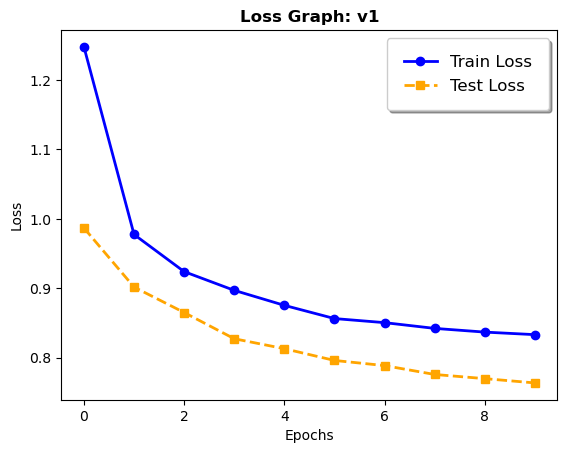

In [136]:
# # Plot graph save
# save_loss_plot(train_loss_array, test_loss_array)

In [ ]:
# # Accuracy graph save
# save_acc_plot()

In [ ]:
# Model save
#torch.save(model, f"model_v{VERSION+1}.pt")